In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, LinearRegression
import altair as alt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
### BEGIN starter code 
def fit_and_report(model, X, y, Xv, yv, mode = 'regression'):
    """
    report the error of a model, if it is a regression model, scoring uses mean square error
    if it is a classification model, scoring uses regular accuray
    
    Parameters
    ----------
    X: numpy.ndarray        
        The X part of the train set
    y: numpy.ndarray
        The y part of the train set    
    Xv: numpy.ndarray        
        The X part of the validation set
    yv: numpy.ndarray
        The y part of the validation set 
    model: string 
        whether the model is a 'regression' model or 'classification',
        default value is 'regression'
        
    Returns
    -------
        errors: float
    """
    model.fit(X, y)
    if mode.lower().startswith('regress'):
        errors = [mean_squared_error(y, model.predict(X)), mean_squared_error(yv, model.predict(Xv))]
    if mode.lower().startswith('classif'):
        errors = [1 - model.score(X,y), 1 - model.score(Xv,yv)]        
    return errors
### END starter code 

In [4]:
X_train = pd.read_csv('data/processed/X_train.csv')
y_train = pd.read_csv('data/processed/y_train.csv')
X_test = pd.read_csv('data/processed/X_test.csv')
y_test = pd.read_csv('data/processed/y_test.csv')

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### The results are not so satisfactory, we will try perform feature selection 

In [6]:
#  Let' see how many features we have 

len(X_train.columns)

11

In [7]:
df = pd.DataFrame(columns = ['n_features_to_select','Train_error', 'Test_error']) 

for n in range(1,11):
    lr = LinearRegression()
    rfe = RFE(estimator = lr, n_features_to_select = n)
    rfe.fit(X_train, y_train)
    X_train_sel = X_train_scaled[:, rfe.support_]
    X_test_sel = X_test_scaled[:, rfe.support_]
    errors = fit_and_report(lr, X_train_sel, y_train, X_test_sel, y_test, mode='regression')
    df = df.append({'n_features_to_select':n, 'Train_error':errors[0], 'Test_error':errors[1]},ignore_index = True)

In [8]:
df = pd.melt(df, id_vars=['n_features_to_select'], value_vars=['Train_error','Test_error'],
            var_name='error_type', value_name='value')

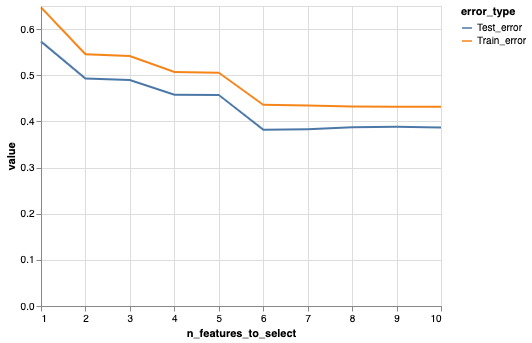

In [9]:
feature_plot = alt.Chart(df).mark_line().encode(
    x='n_features_to_select',
    y='value',
    color = 'error_type'
)



In [10]:
feature_plot.configure(
    numberFormat="0.4f"
).properties(
    title = "The relationship between MSE and number of features",
    width = 800,
    height = 400
).save("ranked_features.png")

In [11]:
lr = LinearRegression()
rfe = RFE(estimator = lr, n_features_to_select = 6)
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=6, step=1, verbose=0)

In [44]:
X_train_sel = X_train_scaled[:, rfe.support_]
X_test_sel = X_test_scaled[:, rfe.support_]

lr.fit(X_train_sel,y_train)

# errors = fit_and_report(lr, X_train_sel, y_train, X_test_sel, y_test, mode='regression')
# print('Train error %0.3f'%(errors[0]))
# print('Test error %0.3f'%(errors[1]))



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [51]:
relevant_features_bool=rfe.support_

In [56]:
relevant_features_list = pd.DataFrame(list(X_train.iloc[:,relevant_features_bool].columns))
relevant_features_list

,0
0,volatile_acidity
1,chlorides
2,density
3,ph
4,sulphates
5,alcohol


In [57]:
lr.coef_[0]

array([-0.19333982, -0.09256997, -0.01419321, -0.07213299,  0.1438033 ,
        0.32665972])

In [58]:
relevant_features_list['weights'] = lr.coef_[0]
relevant_features_list= relevant_features_list.rename(columns={0: "features"})
relevant_features_list

,features,weights
0,volatile_acidity,-0.193340
1,chlorides,-0.092570
2,density,-0.014193
3,ph,-0.072133
4,sulphates,0.143803
5,alcohol,0.326660


In [60]:

feature_weight_plot = alt.Chart(relevant_features_list).mark_bar().encode(
    x='features:N',
    y='weights'
)

feature_weight_plot.configure(
    numberFormat="0.4f"
).properties(
    title = "The feature weights",
    width = 800,
    height = 400
).save("feature_weight_plot.png")





In [17]:
y_pred_df = pd.DataFrame(lr.predict(X_test_sel))
y_pred_df = y_pred_df.rename(columns={0: "predicted"})


In [18]:
y_true_df = y_test.rename(columns={'quality': "actual"})

In [19]:
result_df = pd.concat([y_pred_df, y_true_df], axis=1)

In [20]:
plot_result = alt.Chart(result_df).mark_circle(size=10,opacity=0.6).encode(
    x='actual:Q',
    y='predicted:Q'
)


plot_result.configure(
    numberFormat="0.4f"
).properties(
    title = "The prediction result",
    width = 800,
    height = 400
).save("prediction_result.png")